In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

kr_holidays = holidays.KR(years=2019)
kr_holidays

{datetime.date(2019, 1, 1): "New Year's Day", datetime.date(2019, 2, 5): "Lunar New Year's Day", datetime.date(2019, 2, 4): "The day preceding of Lunar New Year's Day", datetime.date(2019, 2, 6): "The second day of Lunar New Year's Day", datetime.date(2019, 3, 1): 'Independence Movement Day', datetime.date(2019, 5, 12): 'Birthday of the Buddha', datetime.date(2019, 5, 5): "Children's Day", datetime.date(2019, 5, 6): "Alternative holiday of Children's Day", datetime.date(2019, 5, 1): 'Labour Day', datetime.date(2019, 6, 6): 'Memorial Day', datetime.date(2019, 8, 15): 'Liberation Day', datetime.date(2019, 9, 13): 'Chuseok', datetime.date(2019, 9, 12): 'The day preceding of Chuseok', datetime.date(2019, 9, 14): 'The second day of Chuseok', datetime.date(2019, 10, 3): 'National Foundation Day', datetime.date(2019, 10, 9): 'Hangeul Day', datetime.date(2019, 12, 25): 'Christmas Day'}

In [2]:
import pandas as pd
from datetime import datetime

def is_weekend(date):
    return date.weekday() >= 5

def get_weekends_and_holidays(date):
    if is_weekend(date):
        return 1
    elif date in kr_holidays:
        return 1
    else:
        return 0

In [3]:
custom_info = pd.read_csv('./Customer_info.csv')
discount_info = pd.read_csv('./Discount_info.csv')
marketing_info = pd.read_csv('./Marketing_info.csv')
online_info = pd.read_csv('./Onlinesales_info.csv')
tax_info = pd.read_csv('./Tax_info.csv') # Goods and Services Tax(%)

marketing_info.columns = ['거래날짜','오프라인비용','온라인비용']
tp = {j:i+1 for i,j in zip(range(12),discount_info['월'].unique())}
discount_info['월'] = [tp[i] for i in discount_info['월']]

data = pd.merge(online_info,tax_info,on='제품카테고리')
data['월'] = data['거래날짜'].apply(lambda x:int(x.split('-')[1]))
data = pd.merge(data,custom_info,on='고객ID')
data = pd.merge(data,marketing_info,on='거래날짜')
data['거래날짜'] = pd.to_datetime(data['거래날짜'])
data['휴일'] = data['거래날짜'].apply(lambda x:get_weekends_and_holidays(x))
data = pd.merge(data,discount_info,on=['월','제품카테고리'])
data['제품ID'] = data['제품ID'].apply(lambda x:x.split('_')[1]).astype('int32')

for tar in ['수량','평균금액','배송료']:
    data[tar] = data[tar].astype('float32')
    
data = data.drop('쿠폰코드',axis=1)
for i in tqdm(range(len(data))):
    tp = data.loc[i,:]
    if tp ['쿠폰상태'] != 'Clicked':
        data.loc[i,'할인율'] = 0
        
data['지불금액'] = (data['수량']*data['평균금액'])*((100-data['할인율'])/100)+data['배송료']
data['총마케팅비용'] = data['오프라인비용'] + data['온라인비용']

data

100%|██████████████████████████████████████████████████████████████████████████| 52524/52524 [00:06<00:00, 7882.39it/s]


,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,GST,월,성별,고객지역,가입기간,오프라인비용,온라인비용,휴일,할인율,지불금액,총마케팅비용
0,USER_1358,Transaction_0000,2019-01-01,981,Nest-USA,1.0,153.710007,6.5,Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,160.210007,6924.50
1,USER_1358,Transaction_0001,2019-01-01,981,Nest-USA,1.0,153.710007,6.5,Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,160.210007,6924.50
2,USER_1358,Transaction_0013,2019-01-01,983,Nest-USA,2.0,122.769997,6.5,Not Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,252.039993,6924.50
3,USER_1358,Transaction_0015,2019-01-01,984,Nest-USA,1.0,81.500000,6.5,Clicked,0.10,1,남,Chicago,12,4500,2424.50,1,10,79.850000,6924.50
4,USER_1358,Transaction_0016,2019-01-01,981,Nest-USA,1.0,153.710007,6.5,Clicked,0.10,1,남,Chicago,12,4500,2424.50,1,10,144.839006,6924.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,USER_0227,Transaction_4392,2019-03-10,911,Gift Cards,1.0,250.000000,0.0,Clicked,0.05,3,여,California,8,2500,1294.22,1,30,175.000000,3794.22
52520,USER_1423,Transaction_5483,2019-03-28,910,Gift Cards,1.0,25.000000,0.0,Used,0.05,3,남,Chicago,34,2000,1066.12,0,0,25.000000,3066.12
52521,USER_0919,Transaction_18394,2019-10-06,959,Notebooks & Journals,1.0,10.800000,6.0,Clicked,0.05,10,남,California,15,3000,2230.76,1,10,15.720000,5230.76
52522,USER_0919,Transaction_18394,2019-10-06,964,Notebooks & Journals,1.0,9.600000,6.0,Used,0.05,10,남,California,15,3000,2230.76,1,0,15.600000,5230.76


In [42]:
marketing_info['매출액'] = data[['거래날짜','지불금액']].groupby('거래날짜').sum()['지불금액'].values
marketing_info

,거래날짜,오프라인비용,온라인비용,매출액
0,2019-01-01,4500,2424.50,8043.162056
1,2019-01-02,4500,3480.36,13441.706154
2,2019-01-03,4500,1576.38,26129.341265
3,2019-01-04,4500,2928.55,16887.003139
4,2019-01-05,4500,4055.30,18711.706117
...,...,...,...,...
360,2019-12-27,4000,3396.87,11952.995165
361,2019-12-28,4000,3246.84,10083.647155
362,2019-12-29,4000,2546.58,10815.190153
363,2019-12-30,4000,674.31,7264.164004


# 마케팅 비용에 따른 효과분석

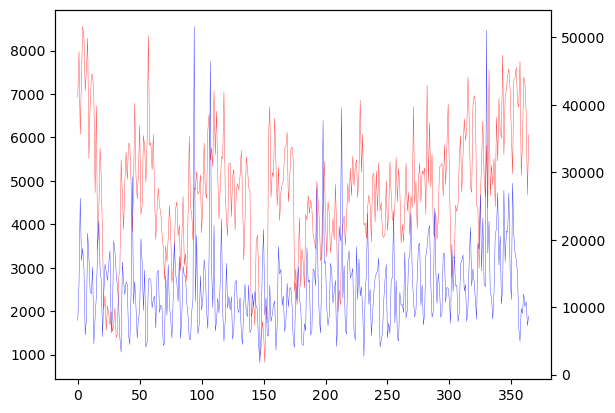

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data[['거래날짜','총마케팅비용']].groupby('거래날짜').mean().values, color='red', alpha=0.8, lw=0.3)
ax2.plot(data[['거래날짜','지불금액']].groupby('거래날짜').sum().values, color='blue', alpha=0.8, lw=0.3)

# 구매성향 정의, 분류, 그룹수와 특징

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s]


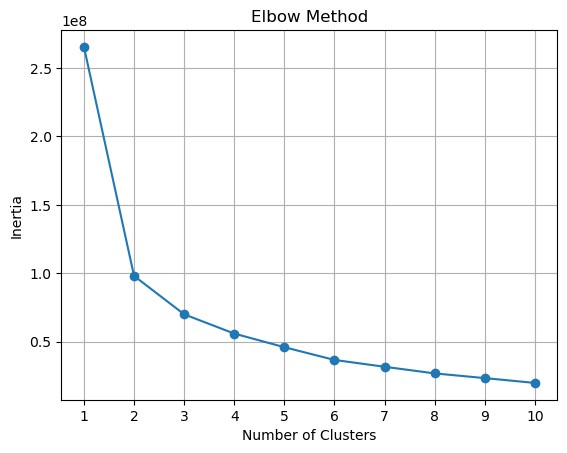

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


target = ['제품카테고리','수량','평균금액','배송료','쿠폰상태','휴일','할인율']
tp = data[target]
encoder = LabelEncoder()
for i in ['제품카테고리','쿠폰상태']:
    tp[i] = encoder.fit_transform(tp[i])

clusters_range = range(1, 11)
inertia = []

# 각 클러스터 개수에 대해 k-means 수행
for k in tqdm(clusters_range):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tp)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 시각화
plt.plot(clusters_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(clusters_range)
plt.grid()
plt.show()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

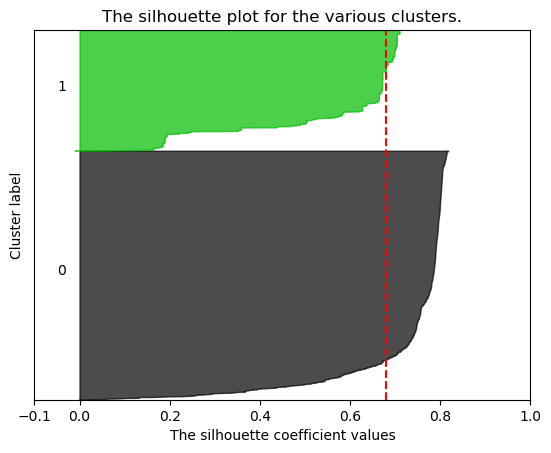

 33%|████████████████████████████                                                        | 1/3 [00:47<01:34, 47.24s/it]

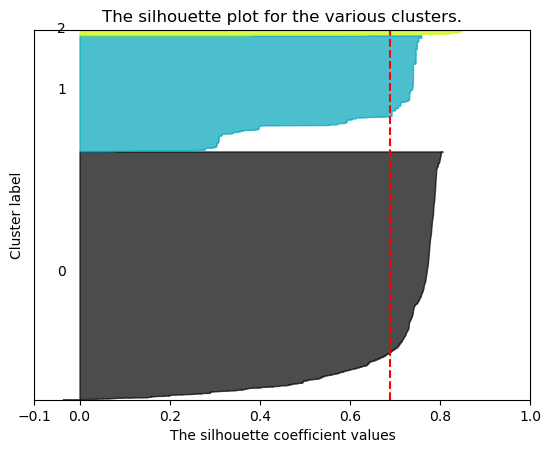

 67%|████████████████████████████████████████████████████████                            | 2/3 [01:34<00:47, 47.10s/it]

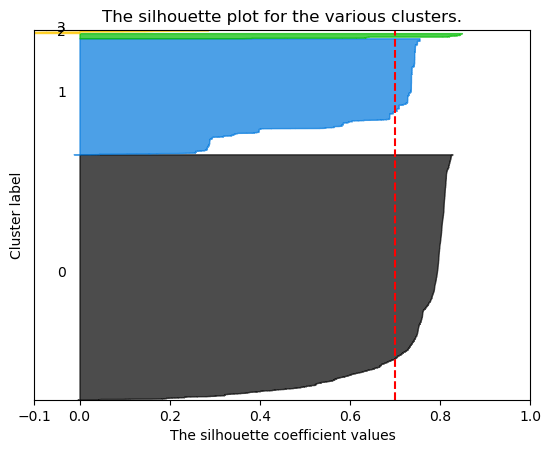

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:21<00:00, 47.19s/it]


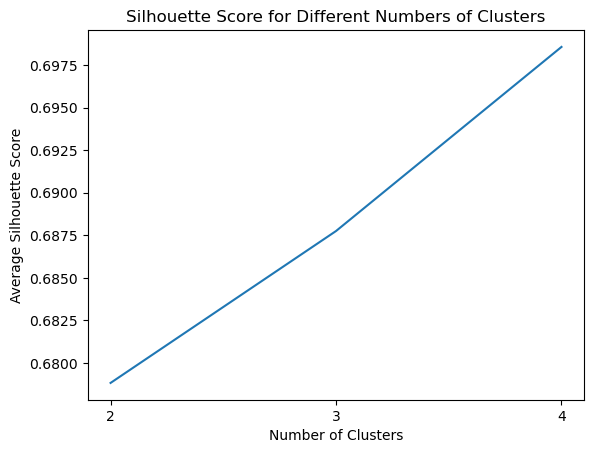

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# 가상의 데이터 생성

# 클러스터 개수 범위 지정
clusters_range = range(2, 5)
silhouette_avg_list = []

for n_clusters in tqdm(clusters_range):
    # KMeans 모델 생성
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(tp)
    
    # 모든 데이터 포인트의 실루엣 스코어 계산
    silhouette_avg = silhouette_score(tp, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    
    # 각 데이터 포인트의 실루엣 스코어 계산
    sample_silhouette_values = silhouette_samples(tp, cluster_labels)

    # 실루엣 스코어 시각화
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(tp) + (n_clusters + 1) * 10])
    y_lower = 10

    for i in range(n_clusters):
        # 클러스터 i에 속하는 데이터의 실루엣 스코어를 정렬
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 다음 클러스터를 그리기 위한 공백

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # y축 라벨은 제거
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


In [54]:
target = ['제품카테고리','수량','평균금액','배송료','쿠폰상태','휴일','할인율']
tp = data[target]
encoder = LabelEncoder()
for i in ['제품카테고리','쿠폰상태']:
    tp[i] = encoder.fit_transform(tp[i])
scaler = StandardScaler()    
tp = scaler.fit_transform(tp)
# pca = PCA(n_components=2)
# tp = pd.DataFrame(pca.fit_transform(tp),columns=['x','y'])
# tp.plot.scatter('x','y',s=3)

tp = pd.DataFrame(tp)
kmeans = KMeans(n_clusters=2,init='k-means++')
labels = kmeans.fit_predict(tp)
tp['label'] = labels
data['label'] = labels
tp

,0,1,2,3,4,5,6,label
0,0.899836,-0.173621,1.578665,-0.20560,1.293733,1.356487,-0.879558,1
1,0.899836,-0.173621,1.578665,-0.20560,1.293733,1.356487,-0.879558,1
2,0.899836,-0.124018,1.096404,-0.20560,0.188211,1.356487,-0.879558,1
3,0.899836,-0.173621,0.453128,-0.20560,-0.917312,1.356487,-0.011046,0
4,0.899836,-0.173621,1.578665,-0.20560,-0.917312,1.356487,-0.011046,0
...,...,...,...,...,...,...,...,...
52519,-0.323258,-0.173621,3.079537,-0.54164,-0.917312,1.356487,1.725979,0
52520,-0.323258,-0.173621,-0.427537,-0.54164,1.293733,-0.737199,-0.879558,1
52521,1.103685,-0.173621,-0.648872,-0.23145,-0.917312,1.356487,-0.011046,0
52522,1.103685,-0.173621,-0.667577,-0.23145,1.293733,1.356487,-0.879558,1


In [63]:
data[['고객ID','label','제품카테고리','고객지역']].groupby(['label','제품카테고리']).value_counts(normalize=True)

label  제품카테고리       고객ID       고객지역         
0      Accessories  USER_1355  California       0.032000
                    USER_0232  Chicago          0.032000
                    USER_0234  Chicago          0.024000
                    USER_0643  California       0.024000
                    USER_0794  Chicago          0.024000
                                                  ...   
1      Waze         USER_0967  California       0.003663
                    USER_0667  Chicago          0.003663
                    USER_0664  Chicago          0.003663
                    USER_0102  Washington DC    0.003663
                    USER_1467  New Jersey       0.003663
Length: 13367, dtype: float64